In [570]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU

First, clean up the data set to make testing easier. A few important things to note:
    -  Analysing data from too far in the past is not very applicable to today's markets, e.g. NYA in the 1960's. Further, some stock exchanges do not have data that far in the past, either due to lack of data or the exchange not existing. Thus to allow for cross comparison of exchanges we will normalise the data sets such that they all start in the 2000's.
    -  Convert the open and close with returns

In [547]:
df = pd.read_csv("indexProcessed.csv")
var = "2007-09-24"
df['Date'] = pd.to_datetime(df['Date'])
df = df[(df['Date'].dt.strftime('%Y-%m-%d')) >= var]
df.drop(columns="Volume", inplace=True)
df

,Index,Date,Open,High,Low,Close,Adj Close,CloseUSD
5129,HSI,2007-09-24,26002.09961,26635.26953,25994.77930,26551.93945,26551.93945,3451.752129
5130,HSI,2007-09-25,26388.85938,26667.24023,26236.73047,26430.28906,26430.28906,3435.937578
5131,HSI,2007-09-27,26664.78906,27166.00977,26664.78906,27065.15039,27065.15039,3518.469551
5132,HSI,2007-09-28,27126.13086,27254.97070,26899.48047,27142.47070,27142.47070,3528.521191
5133,HSI,2007-10-02,27816.91992,28256.80078,27795.55078,28199.75000,28199.75000,3665.967500
...,...,...,...,...,...,...,...,...
104219,J203.JO,2021-05-25,66054.92188,66812.45313,66022.97656,66076.67969,66076.67969,4625.367578
104220,J203.JO,2021-05-26,66076.67969,66446.36719,66030.35156,66108.22656,66108.22656,4627.575859
104221,J203.JO,2021-05-27,66108.22656,66940.25000,66102.54688,66940.25000,66940.25000,4685.817500
104222,J203.JO,2021-05-28,66940.25000,67726.56250,66794.60938,67554.85938,67554.85938,4728.840157


In [548]:
# list of all indexes
index_list = []

# create folder for splitting the original csv 
if not os.path.exists("data_by_index"): os.makedirs("data_by_index")
# split the original csv into index only
for (index), group in df.groupby('Index'):
     group.to_csv(f'data_by_index/{index}.csv', index=False)
     index_list.append({index})

# example csv split
pd.read_csv("data_by_index/NYA.csv").set_index("Date")

,Index,Open,High,Low,Close,Adj Close,CloseUSD
Date,,,,,,,
2007-09-24,NYA,9981.820313,10012.459960,9936.769531,9946.419922,9946.419922,9946.419922
2007-09-25,NYA,9946.129883,9946.129883,9868.950195,9933.820313,9933.820313,9933.820313
2007-09-26,NYA,9933.910156,10001.299810,9929.910156,9980.120117,9980.120117,9980.120117
2007-09-27,NYA,9980.320313,10062.530270,9980.320313,10056.950200,10056.950200,10056.950200
2007-09-28,NYA,10056.950200,10078.059570,10013.000000,10039.280270,10039.280270,10039.280270
...,...,...,...,...,...,...,...
2021-05-24,NYA,16375.000000,16508.519530,16375.000000,16464.689450,16464.689450,16464.689450
2021-05-25,NYA,16464.689450,16525.810550,16375.150390,16390.189450,16390.189450,16390.189450
2021-05-26,NYA,16390.189450,16466.339840,16388.320310,16451.960940,16451.960940,16451.960940


In [549]:
nya_df = pd.read_csv("data_by_index/NYA.csv").set_index("Date")
tko_df = pd.read_csv("data_by_index/N225.csv").set_index("Date")

# Log return function
def lg_return(df):
    lg_return_list = []
    for index, row in df.iterrows():
        lg_return_list.append((np.log(row["Close"]) - np.log(row["Open"])))
    return lg_return_list

# Log return function
def returns(df):
    lg_return_list = []
    for index, row in df.iterrows():
        lg_return_list.append(row["Close"]/row["Open"] - 1)
    return lg_return_list

# insert log returns to each dataset
nya_df.insert(7, "Daily Log Returns", lg_return(nya_df))
tko_df.insert(7, "Daily Log Returns", lg_return(tko_df))


In [550]:
# even out the dataframes such that they have the same dates
def even_out_frames(df1, df2):
    
    df1_index = df1.index.to_numpy()
    for index, row in df2.iterrows():
        if index not in df1_index:
            df2.drop(index=index, inplace=True)
    
    df2_index = df2.index.to_numpy()
    for index, row in df1.iterrows():
        if index not in df2_index:
                df1.drop(index=index, inplace=True)
    return 0

even_out_frames(tko_df, nya_df)
tko_df

,Index,Open,High,Low,Close,Adj Close,CloseUSD,Daily Log Returns
Date,,,,,,,,
2007-09-25,N225,16317.19043,16434.80078,16240.25977,16401.73047,16401.73047,164.017305,0.005168
2007-09-26,N225,16388.50977,16457.72070,16388.50977,16435.74023,16435.74023,164.357402,0.002878
2007-09-27,N225,16551.93945,16868.93945,16551.93945,16832.22070,16832.22070,168.322207,0.016792
2007-09-28,N225,16903.64063,16929.25977,16755.21094,16785.68945,16785.68945,167.856895,-0.007002
2007-10-01,N225,16773.09961,16899.83984,16685.80078,16845.96094,16845.96094,168.459609,0.004335
...,...,...,...,...,...,...,...,...
2021-05-24,N225,28212.32031,28584.17969,28212.32031,28364.60938,28364.60938,283.646094,0.005383
2021-05-25,N225,28516.99023,28576.97070,28443.74023,28553.98047,28553.98047,285.539805,0.001296
2021-05-26,N225,28396.61914,28710.83008,28396.61914,28642.18945,28642.18945,286.421895,0.008611


In [551]:
tko_close = tko_df["Close"]

nya_df.insert(8, "Prev Tokyo Close", tko_close)

tko_df.drop(index=tko_df.index[0], inplace=True)

tko_open = tko_df["Open"]

tko_open = np.append(tko_open,0)

nya_df.insert(9, "Next Tokyo Open", tko_open)
nya_df.drop(index=nya_df.index[len(nya_df) - 1], inplace=True)

In [552]:
nya_df

,Index,Open,High,Low,Close,Adj Close,CloseUSD,Daily Log Returns,Prev Tokyo Close,Next Tokyo Open
Date,,,,,,,,,,
2007-09-25,NYA,9946.129883,9946.129883,9868.950195,9933.820313,9933.820313,9933.820313,-0.001238,16401.73047,16388.50977
2007-09-26,NYA,9933.910156,10001.299810,9929.910156,9980.120117,9980.120117,9980.120117,0.004641,16435.74023,16551.93945
2007-09-27,NYA,9980.320313,10062.530270,9980.320313,10056.950200,10056.950200,10056.950200,0.007649,16832.22070,16903.64063
2007-09-28,NYA,10056.950200,10078.059570,10013.000000,10039.280270,10039.280270,10039.280270,-0.001759,16785.68945,16773.09961
2007-10-01,NYA,10039.299810,10196.919920,10039.299810,10184.500000,10184.500000,10184.500000,0.014360,16845.96094,17027.91992
...,...,...,...,...,...,...,...,...,...,...
2021-05-21,NYA,16350.450200,16475.000000,16344.759770,16375.000000,16375.000000,16375.000000,0.001500,28317.83008,28212.32031
2021-05-24,NYA,16375.000000,16508.519530,16375.000000,16464.689450,16464.689450,16464.689450,0.005462,28364.60938,28516.99023
2021-05-25,NYA,16464.689450,16525.810550,16375.150390,16390.189450,16390.189450,16390.189450,-0.004535,28553.98047,28396.61914


In [553]:
min_max_scaler = MinMaxScaler()

nya_df.drop(columns=["CloseUSD", "Adj Close"], inplace=True)

scaled_data =  min_max_scaler.fit_transform(nya_df.drop(columns=["Index", "Daily Log Returns"]).values)

y_data = scaled_data[:, 5]

x_data = np.delete(scaled_data,  5, axis=1)

nya_train, nya_test, tko_open_train, tko_open_test = train_test_split(x_data,
                                                      y_data, 
                                                      test_size=0.20,
                                                      shuffle=False)

nya_train= np.reshape(nya_train, (nya_train.shape[0], nya_train.shape[1], 1))

scaled_data.shape

(3228, 6)

In [554]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (nya_train.shape[1],1)))
model.add(GRU(128, return_sequences=False))
model.add(Dense(32))
model.add(Dense(1))
model.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_42 (LSTM)              (None, 5, 128)            66560     
                                                                 
 gru_40 (GRU)                (None, 128)               99072     
                                                                 
 dense_80 (Dense)            (None, 32)                4128      
                                                                 
 dense_81 (Dense)            (None, 1)                 33        
                                                                 
Total params: 169,793
Trainable params: 169,793
Non-trainable params: 0
_________________________________________________________________


In [555]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(nya_train, tko_open_train, batch_size= 1, epochs=30)

Epoch 1/30
2582/2582 [==============================] - 14s 5ms/step - loss: 0.0011
Epoch 2/30
2582/2582 [==============================] - 13s 5ms/step - loss: 2.6691e-04
Epoch 3/30
2582/2582 [==============================] - 13s 5ms/step - loss: 2.0163e-04
Epoch 4/30
2582/2582 [==============================] - 14s 5ms/step - loss: 1.9283e-04
Epoch 5/30
2582/2582 [==============================] - 14s 5ms/step - loss: 1.3702e-04
Epoch 6/30
2582/2582 [==============================] - 13s 5ms/step - loss: 1.9437e-04
Epoch 7/30
2582/2582 [==============================] - 13s 5ms/step - loss: 1.0667e-04
Epoch 8/30
2582/2582 [==============================] - 13s 5ms/step - loss: 1.2621e-04
Epoch 9/30
2582/2582 [==============================] - 13s 5ms/step - loss: 9.8123e-05
Epoch 10/30
2582/2582 [==============================] - 13s 5ms/step - loss: 7.9303e-05
Epoch 11/30
2582/2582 [==============================] - 12s 5ms/step - loss: 8.6407e-05
Epoch 12/30
2582/2582 [===========

In [556]:
nya_test = np.reshape(nya_test, (nya_test.shape[0], nya_test.shape[1], 1))
prediction = model.predict(nya_test)

print(prediction.shape)
print(nya_test.shape)

21/21 [==============================] - 1s 4ms/step
(646, 1)
(646, 5, 1)


In [572]:
def format_df(arr, columns):
    data = {}
    for i in range(len(columns)):
        data[columns[i]] = arr[:, i]
    return pd.DataFrame(data=data)

def inverse(x,y):
    final = np.append(x, y.reshape(y.shape[0],1,1), axis=1)
    print(x.shape, y.shape, final.shape)
    final = final.reshape(x.shape[0],x.shape[1]+1)
    final_trans = min_max_scaler.inverse_transform(final)
    return final_trans

In [573]:
pred_df = format_df(inverse(nya_test, prediction), columns=["Open", "High", "Low", "Close", "Prev Tokyo Close", "Predicted Next Tokyo Open"])
pred_df.insert(6, "Actual Next Tokyo Open", inverse(nya_test, tko_open_test)[:, 5])
pred_df

(646, 5, 1) (646, 1) (646, 6, 1)
(646, 5, 1) (646,) (646, 6, 1)


,Open,High,Low,Close,Prev Tokyo Close,Predicted Next Tokyo Open,Actual Next Tokyo Open
0,12998.04004,13032.25000,12993.95020,12996.75977,22219.73047,22097.227749,22270.03906
1,13007.57031,13013.05957,12983.01953,12990.50977,22362.55078,22236.381982,22420.66992
2,12978.58984,12988.20996,12922.83984,12933.45996,22410.82031,22266.862604,22484.00977
3,12968.82031,13011.69043,12964.29981,12999.44043,22601.76953,22466.402950,22693.68945
4,13043.42969,13110.70020,13043.42969,13102.03027,22799.64063,22667.396407,22967.74023
...,...,...,...,...,...,...,...
641,16350.45020,16475.00000,16344.75977,16375.00000,28317.83008,27893.265198,28212.32031
642,16375.00000,16508.51953,16375.00000,16464.68945,28364.60938,27979.648959,28516.99023
643,16464.68945,16525.81055,16375.15039,16390.18945,28553.98047,28072.074386,28396.61914
644,16390.18945,16466.33984,16388.32031,16451.96094,28642.18945,28191.507415,28543.32031


<AxesSubplot: >

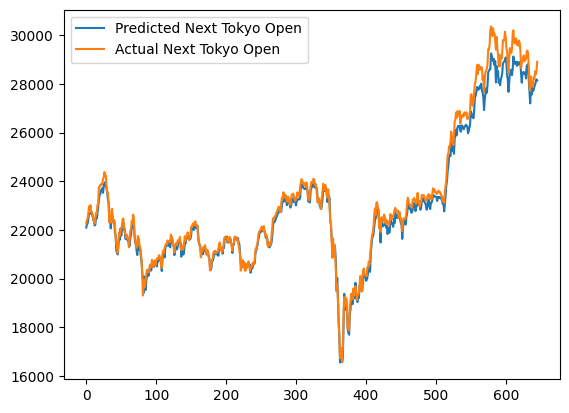

In [574]:
ax = pred_df.plot(y="Predicted Next Tokyo Open")

pred_df.plot(ax = ax, y="Actual Next Tokyo Open")

In [575]:
mean_absolute_percentage_error(y_true=pred_df["Actual Next Tokyo Open"], y_pred= pred_df["Predicted Next Tokyo Open"])

0.011347690598833485